# TopoCluster Regression

This is a simple, stripped-down notebook for training networks. I've removed most of the models that are present in `TopoClusterRegressionRewrite.ipynb`, as well as most of the plots (I find that the multitude of plots makes things a bit cumbersome and hard to navigate -- I'll see if I can change the way they are displayed later on).

Here, we just train the so-called `all` model, which uses images from all $6$ calo layers. We train two versions, for charged and neutral pions.

#### 1) Initial setup

In [1]:
# ML fitting/loading/saving settings
loadModel = False # if false, then run trainings directly. otherwise load the file.
saveModel = True # if true, save the current model to disk.

Now let's choose our training data (and associated strategy).

In [2]:
# training data choice
# options are jet, pion, pion_reweighted
strat = 'pion'

In [3]:
# Import some basic libraries.
import sys, os, uuid, glob, pickle
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import uproot as ur
import ROOT as rt # used for plotting
from numba import jit

# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu
from util import io_util         as iu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression/Plots/'
modelpath = path_prefix + 'regression/Models/'
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.22/02


#### 2) Get the data.

Let me lay out some definitions, so it's clear as to what the data is.

We have a number of different "strategies" (the `strat` variable at the top). These correspond to different choices of training, validation and testing datasets.

1. `pion`: We train and validate the network using our pion gun data.

2. `pion_reweighted`: This is the same as `pion`, except that our training data is reweighted using a jet dataset (via their reco topo-cluster $p_T$ distributions), that corresponds with QCD dijet events.

3. `jet`: We train and validate the network using our jet data. This is a facsimile dataset -- we do not know the actual labels of the jet data topo-clusters, so we have assigned labels by matching clusters to truth-level pions in $(\eta,\phi)$.

The validation performed for these networks is effectively being done on some "holdout" dataset from training -- it will by definition have similar kinematics, being drawn from the same set of events. The more interesting test -- how our energy regression performs in tandem with classification on our *unlabeled* jet dataset, will be handled in a separate notebook.

In [4]:
# now determine which files we get training and validation data from. Depends on our strategy.
if(strat == 'pion' or strat == 'pion_reweighted'):
    data_dir = path_prefix + 'data/pion/'
    data_filenames = {'pp':data_dir+'piplus.root','pm':data_dir+'piminus.root','p0':data_dir+'pi0.root'}
    
elif(strat == 'jet'):
    data_dir = path_prefix + 'jets/training/'
    data_filenames = {'pp':data_dir+'piplus.root','p0':data_dir+'pi0.root'}

# adjust our model and plot paths, so that they are unique for each strategy
paths = [modelpath, plotpath]
for i in range(len(paths)):
    path = paths[i]
    path = path + strat
    try: os.makedirs(path)
    except: pass
    path = path + '/'
    paths[i] = path
modelpath, plotpath = paths

# we get uproot trees and pandas DataFrames,
# for training + validation
tree_name = 'ClusterTree'
branches = ['truthE', 'clusterE', 'clusterPt', 'clusterEta', 'cluster_ENG_CALIB_TOT']

data_trees = {key:ur.open(val)[tree_name] for key,val in data_filenames.items()}
data_frames = {key:val.pandas.df(branches,flatten=False) for key,val in data_trees.items()}

#### Preparing training, validation and testing samples

Here, we're going to arrange our dataset into training, validation and testing samples (by defining the indices of these categories).


As we're taking logarithms  of `clusterE` and `cluster_ENG_CALIB_TOT`, we will always perform cuts to have `clusterE` > 0 for all datasets, and `cluster_ENG_CALIB_TOT` > 0 for training. 

On top of those cuts, we're free to apply additional cuts to training, validation and testing data. We can do them below, as we pick event indices for each dataset.

Since we treat $\pi^+$ and $\pi^-$ as the same, let's combine them so that we have *charged* and *neutral* pions. We will store all the charged pions under the key `pp`, and delete the key `pm`.

In [5]:
key_conversion = {'pp':'charged pion','p0':'neutral pion'}
# combining dataframes
if('pm' in data_frames.keys()):
    data_frames['pp'] = data_frames['pp'].append(data_frames['pm'])
    del data_frames['pm']
    
    data_trees['pp'] = [data_trees['pp'],data_trees['pm']]
    data_trees['p0'] = [data_trees['p0']]
    del data_trees['pm']

In [6]:
training_frames = {}
validation_frames = {}

# First, the minimum energy cut that we will always apply to data. Anything that fails to pass this cut will be discarded,
# we will never evaluate on events that don't pass this cut.
global_energy_cut = 0.

# We apply a lower cut on cluster_ENG_CALIB_TOT, as very low-energy clusters can throw off training.
energy_cut = [0., -1.]
if(strat == 'pion' or strat == 'pion_reweighted'): 
    energy_cut[0] = 0. # GeV (e.g. 5.0e-1 by default)
    energy_cut[1] = -1.
    
elif(strat == 'jet'): 
    energy_cut[0] = 5.0e-2 # GeV
    energy_cut[1] = -1.

data_indices = {} # indices of all usable data, i.e. non-zero energy
training_indices = {} # indices of events actually used for training
validation_indices = {} # indices of events not used for training (but usable)

# percent of events to hand over from training to testing
testing_frac = 0.2
rng = np.random.default_rng() # for shuffling indices when splitting training/testing
for key in data_frames.keys():
    n = len(data_frames[key])
    eng_calib_tot = data_frames[key]['cluster_ENG_CALIB_TOT'].to_numpy()
    selected_indices = eng_calib_tot > energy_cut[0]
    if(energy_cut[1] > 0.): selected_indices = selected_indices * (eng_calib_tot < energy_cut[1])
    
    selected_indices = selected_indices.nonzero()[0] # from boolean array to a list of actual indices
    rng.shuffle(selected_indices)
    n_test = int(testing_frac * len(selected_indices))
    
    # making boolean arrays to select events -- arrays are of same length as dataframe
    validation_indices[key] = np.full(n,False)
    training_indices[key] = np.full(n,False)
    validation_indices[key][np.sort(selected_indices[:n_test])] = True
    training_indices[key][np.sort(selected_indices[n_test:])] = True

    data_indices[key] = (data_frames[key]['cluster_ENG_CALIB_TOT'] > global_energy_cut).to_numpy()
    data_frames[key] = data_frames[key][data_indices[key]]

In [7]:
for key in data_frames.keys():
    print('Number of {type} training/testing events: {val1}/{val2}'.format(type=key_conversion[key], val1 = np.sum(training_indices[key]), val2 = np.sum(validation_indices[key])))

Number of charged pion training/testing events: 699001/174750
Number of neutral pion training/testing events: 211334/52833


Note that we have many more charged pions than neutral pions, so this *may* result in our charged pion regression being better-trained (unless the stats for both are sufficiently high).

### Defining regression variables

Beyond the information already present in the data, we may want to pre-compute some extra regression inputs.

The difference between computing them here, on the whole dataset, versus doing it in batch as part of the network itself, is that we can also define some `scalers` based on these variables. This will allow us to scale them across the dataset, for example to get them into the interval of \[0,1\].

In [8]:
m = 1.
b = 1.
EnergyMapping = iu.LinLogMapping(b=b,m=m)

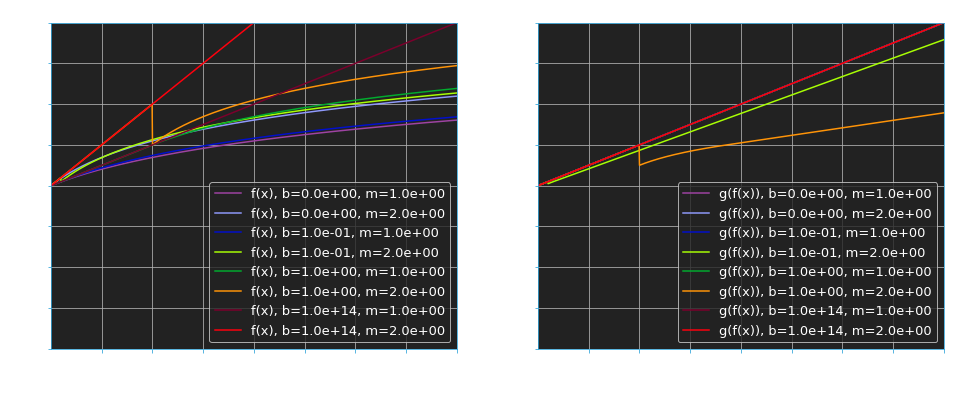

In [9]:
# Perform a test of our mapping to demonstrate its numerical stability
x=np.linspace(0.001,4.,1000)
b_vals=[0.,.1,1.,1.0e14]
m_vals=[1.,2.]
iu.MapStabilityTest(iu.LinLogMapping, b_vals=b_vals, m_vals=m_vals, x=x, ps=plotstyle, savedir=plotpath)

It looks like our `LinLogMapping` is pretty numerically stable as long as $b \gg m$. I think this is the expected behaviour, given the instabilities with logarithms that we've seen before.

In [10]:
# some regression vars
for key,frame in data_frames.items():
    frame['logE'] = EnergyMapping.Forward(frame['clusterE'].to_numpy())
    frame['logECalib'] = EnergyMapping.Forward(frame['cluster_ENG_CALIB_TOT'].to_numpy())

In [11]:
from sklearn.preprocessing import StandardScaler

# create scalers
scaler_e = {key:StandardScaler() for key in data_frames.keys()}
scaler_cal = {key:StandardScaler() for key in data_frames.keys()}
scaler_eta = {key:StandardScaler() for key in data_frames.keys()}

# fit our scalers, using the training data
for key, frame in data_frames.items():
    scaler_e[key].fit(frame['logE'][training_indices[key]].to_numpy().reshape(-1,1))
    scaler_cal[key].fit(frame['logECalib'][training_indices[key]].to_numpy().reshape(-1,1))
    scaler_eta[key].fit(frame['clusterEta'][training_indices[key]].to_numpy().reshape(-1,1))

# apply the scalers to all data
for key, frame in data_frames.items():
    frame['s_logE'] = scaler_e[key].transform(frame['logE'].to_numpy().reshape(-1,1))
    frame['s_logECalib'] = scaler_cal[key].transform(frame['logECalib'].to_numpy().reshape(-1,1))
    frame['s_eta'] = scaler_eta[key].transform(frame['clusterEta'].to_numpy().reshape(-1,1))

In [12]:
import joblib as jl
# now we save our scalers to a file, so that we can use them when evaluating the model elsewhere
scalers = {'e':scaler_e, 'cal':scaler_cal, 'eta':scaler_eta}
scaler_file = modelpath + 'scalers.save'
if(saveModel and not loadModel): jl.dump(scalers,scaler_file)

To finish training data preparation, we concatenate the calorimeter images, and then combine them with columns `s_logE` and `s_Eta`.

Here's a handy function for taking a DataFrame (with our scaler-derived columns) and our tree with calo images, and getting the actual network input we need. The `indices` argument is just used for `dtree`, whereas `dframe` should already have the indices applied.

In [13]:
def CombinedInput(dframe, dtree, indices=-1, input_keys = ['s_logE','s_eta']):
    # Prepare the calo images for input to training.
    l = len(layers) * len(dtree.keys())
    i = 0
    pfx = 'Loading calo images:      '
    sfx = 'Complete'
    bl = 50
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

    calo_images = {}
    for key in dtree.keys():
        calo_images[key] = {}
    
        for layer in layers:
            if(indices != -1): calo_images[key][layer] = mu.setupCells(dtree[key],layer, indices = indices[key])
            else: calo_images[key][layer] = mu.setupCells(dtree[key],layer)
            i += 1
            qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)
        
    # Concatenate images, and prepare our combined input.
    All_input = {}
    keys = list(calo_images.keys())
    l = 3 * len(keys)
    i = 0
    pfx = 'Preparing combined input: '
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

    for key in keys:
        combined_images = np.concatenate(tuple([calo_images[key][layer] for layer in layers]), axis=1)
        del calo_images[key] # delete this element of calo_images, it has been copied and is no longer needed
        i = i + 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

        s_combined,scaler_combined = mu.standardCells(combined_images, layers)
        i = i + 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)
        
        All_input[key] = np.column_stack([dframe[key][x][indices[key]] for x in input_keys] + [s_combined])
        #All_input[key] = np.column_stack((dframe[key]['s_logE'], dframe[key]['s_eta'],s_combined))
        i = i + 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)
    return All_input

The output of the above function is a dictionary whose keys correspond with the different data categories (e.g. `p0` and `pp`, for neutral and charged pions). Each dictionary entry is of shape `(N,938)`. The first dimension is the number of clusters, and the second results from the two inputs for energy and eta, plus the concatenation of all calorimeter images (with $936$ pixels total).

We may optionally perform some re-weighting of our training events. If using the `pion_reweighted` strategy, we will re-weight our single-pion training data to match the topo-cluster $p_T$ spectrum of our jet data.

In [14]:
sample_weights = {}
if(strat == 'pion_reweighted'):
    pt_min = 0.
    pt_max = 20.
    pt_bins = 100
        
    # Get the jet files for reweighting. We look in jets/ to make sure we only use the relevant files.
    jet_files = glob.glob(path_prefix + 'jets/data/pion/*.root')
    
    for key in training_frames.keys():
        h_train    = rt.TH1F(qu.RN(), 'h_train',   pt_bins, pt_min, pt_max)
        h_reweight = rt.TH1F(qu.RN(), 'h_reweight',pt_bins, pt_min, pt_max)

        # fill training distribution
        training_vals = data_frames[key]['clusterPt'][training_indices[key]].to_numpy()
        for entry in training_vals: h_train.Fill(entry)
        h_train.Scale(1./h_train.Integral())
        
        # fill the reweighting distribution
        for file in jet_files:
            for entry in ur.open(file)['ClusterTree'].array('clusterPt').flatten():
                h_reweight.Fill(entry)
        h_reweight.Scale(1./h_reweight.Integral())
        h_reweight = h_reweight / h_train
        
        # now get a list of weights for our events
        sample_weights[key] = np.array([h_reweight.GetBinContent(h_reweight.FindBin(x)) for x in training_vals])
    
#else:  sample_weights = {key:np.full(len(All_input[key]), 1.) for key in All_input.keys()}
    
else:  sample_weights = {key:np.full(int(np.sum(training_indices[key])), 1.) for key in training_indices.keys()}

## Tensorflow/Keras Prep

In this workflow we have the ability to train a number of models -- some will require additional data setup. Here, we have some basic setup they will all use.

In [15]:
models = {} # keep track of the models -- note that we train multiple instances of each model
histories = {} # keep track of histories of the models we train
regressors = {} # keep track of the trained models (will be KerasRegressor objects)
energy_names = {} # keep track of the names of regressed variables

model_filename_suffixes = {
    'pp':'_charged',
    'p0':'_neutral'
}

energy_name_prefix = 'clusterE_pred_'

In [16]:
from keras.wrappers.scikit_learn import KerasRegressor # scikit_learn wrapper -- why do we use this, vs. native tf.keras approach like in classification notebook?
from tensorflow.keras.models import load_model

In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [18]:
from models import baseline_nn_All_model, resnet

## Training "all" model

Here we train a simple, fully-connected neural network that uses the calorimeter cells as input, along with energy and $\eta$.

In [ ]:
# Baseline model
model_key = 'all'
energy_names[model_key] = energy_name_prefix + model_key
lr = 1e-4
decay = 1e-6
dropout = -1. # < 0 -> no dropout
models[model_key] = baseline_nn_All_model(strategy, lr=lr, decay=decay, dropout=dropout)
#print(models[model_key]().summary())

In [ ]:
# Define our regressors (actual networks) that we will fit (train).
batch_size = 200 * ngpu
epochs = 20 # 100
verbose = 1
regressors[model_key] = {key: KerasRegressor(build_fn=models[model_key], batch_size=batch_size, epochs=epochs, verbose=verbose) for key in training_indices.keys()}

In [ ]:
# Prepare the data.
All_input = CombinedInput(data_frames, data_trees, data_indices)

# Train the models and save them, or load them from files.
model_dir = modelpath + '/' + model_key
try: os.makedirs(model_dir)
except: pass

model_file_names = {key: '{}/{}{}.h5'.format(model_dir,model_key,suffix) for key,suffix in model_filename_suffixes.items()}
assert (set(model_file_names.keys()) == set(training_indices.keys()))

histories[model_key] = {}
for key, filename in model_file_names.items():
    if not loadModel: 
        histories[model_key][key] = regressors[model_key][key].fit(
            x=All_input[key][training_indices[key]], 
            y=data_frames[key]['s_logECalib'][training_indices[key]],
            validation_data=(
                All_input[key][validation_indices[key]],
                data_frames[key]['s_logECalib'][validation_indices[key]]
            ),
            sample_weight = sample_weights[key]
        )
    histories[model_key][key] = histories[model_key][key].history
    
    else: 
        regressors[model_key][key].model = load_model(filename)
        with open(filename.replace('.h5','.history'),'rb') as model_history_file:
            histories[model_key][key] = pickle.load(model_history_file)
        
    if saveModel: 
        regressors[model_key][key].model.save(filename)
        with open(filename.replace('.h5','.history'),'wb') as model_history_file:
            pickle.dump(histories[model_key][key], model_history_file)

# Get predictions for all data
for key, frame in data_frames.items():
    frame[energy_names[model_key]] = EnergyMapping.Inverse(scaler_cal[key].inverse_transform(regressors[model_key][key].predict(All_input[key])))

## ResNet

We can also train an implementation of ResNet. More precisely, we use a ResNet model on the calorimeter images, and then mix in the energy and $\eta$ at the output layer.

ResNet will require a little extra data preparation, which we do here.

In [ ]:
# ResNet
model_key = 'resnet'
energy_names[model_key] = energy_name_prefix + model_key
lr = 5e-5
channels = 6
models[model_key] = resnet(strategy, lr=lr, channels=channels)

In [ ]:
# Define our regressors (actual networks) that we will fit (train).
batch_size = 20 * ngpu
epochs = 2 # 20
verbose = 1
input_shape = (128,16)
regressors[model_key] = {key: KerasRegressor(build_fn=models[model_key], input_shape=input_shape, batch_size=batch_size, epochs=epochs, verbose=verbose) for key in training_indices.keys()}

In [19]:
# prepare input for ResNet
l = len(layers) * len(data_trees.keys())
i = 0
pfx = 'Loading calo images:      '
sfx = 'Complete'
bl = 50
qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

rn_input = {}
for key in data_trees.keys():
    rn_input[key] = {}
    
    for layer in layers:
        rn_input[key][layer] = mu.setupCells(data_trees[key],layer, indices=data_indices[key])
        i += 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

# Unflatten images. Note that the key names match those defined within resnet model in models.py, which are currently hard-coded.
for key,imageset in rn_input.items():
    rn_input[key] = {'input' + str(i):imageset[layer].reshape(tuple([-1] + list(cell_shapes[layer]))) for i,layer in enumerate(layers)}
    rn_input[key]['energy'] = data_frames[key]['s_logE'].to_numpy()
    rn_input[key]['eta'   ] = data_frames[key]['s_eta' ].to_numpy()

Loading calo images:       |██████████████████████████████████████████████████| 100.0% Complete


In [20]:
# Now explicitly split things up into training and validation data.
rn_train = {
    key:{
        input_key:val[training_indices[key]] for input_key,val in dset.items()
    }
    for key,dset in rn_input.items()
}

rn_valid = {
    key:{
        input_key:val[validation_indices[key]] for input_key,val in dset.items()
    }
    for key,dset in rn_input.items()
}

# labels
rn_label_train = {key:data_frames[key]['s_logECalib'][training_indices[key]  ] for key in data_frames.keys()}
rn_label_valid = {key:data_frames[key]['s_logECalib'][validation_indices[key]] for key in data_frames.keys()}

In [ ]:
# Train the models and save them, or load them from files.
model_dir = modelpath + '/' + model_key
try: os.makedirs(model_dir)
except: pass

model_file_names = {key: '{}/{}{}.h5'.format(model_dir,model_key,suffix) for key,suffix in model_filename_suffixes.items()}
assert (set(model_file_names.keys()) == set(training_indices.keys()))

histories[model_key] = {}
for key, filename in model_file_names.items():
    if not loadModel:  
        histories[model_key][key] = regressors[model_key][key].fit(
            x=rn_train[key],
            y=rn_label_train[key],
            validation_data=(
                rn_valid[key],
                rn_label_valid[key]
            ),
            sample_weight = sample_weights[key]
        )
        histories[model_key][key] = histories[model_key][key].history

    else: 
        regressors[model_key][key].model = load_model(filename)
        with open(filename.replace('.h5','.history'),'rb') as model_history_file:
            histories[model_key][key] = pickle.load(model_history_file)
    
    if saveModel: 
        regressors[model_key][key].model.save(filename)
        with open(filename.replace('.h5','.history'),'wb') as model_history_file:
            pickle.dump(histories[model_key][key], model_history_file)

# Get predictions for all data.
for key, frame in data_frames.items():
    frame[energy_names[model_key]] = EnergyMapping.Inverse(scaler_cal[key].inverse_transform(regressors[model_key][key].predict(rn_input[key])))

## ResNet Mini

In an effort to simplify our ResNet -- and get it to train faster -- we can consider just using a single channel for our images, corresponding to `EMB1`. We can re-use the input we prepared for our full ResNet, though we'll only need a portion of it and the `input_shape` will simply be the shape of the original input itself (making the scaling redundant).

In [21]:
mini_keys = ['input0','energy','eta']

rn_mini_input = {
    key:{mkey:val[mkey] for mkey in mini_keys}
    for key,val in rn_input.items()
}

rn_mini_train = {
    key:{mkey:val[mkey] for mkey in mini_keys}
    for key,val in rn_train.items()
}

rn_mini_valid = {
    key:{mkey:val[mkey] for mkey in mini_keys}
    for key,val in rn_valid.items()
}

In [22]:
# ResNet
model_key = 'resnet_mini'
energy_names[model_key] = energy_name_prefix + model_key
lr = 5e-5
channels = 1
models[model_key] = resnet(strategy, lr=lr, channels=channels)

In [25]:
# Define our regressors (actual networks) that we will fit (train).
batch_size = 100 * ngpu
epochs = 4 # 20
verbose = 1
input_shape = (128,16)
regressors[model_key] = {key: KerasRegressor(build_fn=models[model_key], input_shape=input_shape, batch_size=batch_size, epochs=epochs, verbose=verbose) for key in training_indices.keys()}

In [26]:
# Train the models and save them, or load them from files.
model_dir = modelpath + '/' + model_key
try: os.makedirs(model_dir)
except: pass

model_file_names = {key: '{}/{}{}.h5'.format(model_dir,model_key,suffix) for key,suffix in model_filename_suffixes.items()}
assert (set(model_file_names.keys()) == set(training_indices.keys()))

histories[model_key] = {}
for key, filename in model_file_names.items():
    if not loadModel:  
        histories[model_key][key] = regressors[model_key][key].fit(
            x=rn_mini_train[key],
            y=rn_label_train[key],
            validation_data=(
                rn_mini_valid[key],
                rn_label_valid[key]
            ),
            sample_weight = sample_weights[key]
        )
        histories[model_key][key] = histories[model_key][key].history

    else: 
        regressors[model_key][key].model = load_model(filename)
        with open(filename.replace('.h5','.history'),'rb') as model_history_file:
            histories[model_key][key] = pickle.load(model_history_file)
    

    if saveModel: 
        regressors[model_key][key].model.save(filename)
        with open(filename.replace('.h5','.history'),'wb') as model_history_file:
            pickle.dump(histories[model_key][key], model_history_file)

# Get predictions for all data.
for key, frame in data_frames.items():
    frame[energy_names[model_key]] = EnergyMapping.Inverse(scaler_cal[key].inverse_transform(regressors[model_key][key].predict(rn_mini_input[key])))

## Plotting results (testing how well our network works)

Now, let's plot some kinematics and network results. We'll make two groups of plots -- one for charged pions and one for neutral pions.

Within each group of plots, we'll make two plots for each quantity -- one made using just the training data, and then one made using all the data (training + whatever we excluded -- but still excluding events with `cluster_ENG_CALIB_TOT` $< 0$ since these blow up network output).

In [ ]:
# for convenience below
training_frames = {key:frame[training_indices[key]] for key,frame in data_frames.items()}
validation_frames = {key:frame[validation_indices[key]] for key,frame in data_frames.items()}

In [ ]:
import importlib
importlib.reload(sys.modules['plotting_utils'])

In [ ]:
from plotting_utils import EnergySummary

for model_key in energy_names.keys():
    results = EnergySummary(
        train_dfs=training_frames, 
        valid_dfs=validation_frames, 
        data_dfs=data_frames, 
        energy_name=energy_names[model_key], 
        model_name=model_key, 
        plotpath=plotpath, 
        extensions=['png'], 
        plot_size=750, 
        strat='pion', 
        full=False,
        ps=plotstyle
    )
    for canv in results['canv'].values(): canv.Draw()

In [ ]:
# Making graphs of the network models
from tensorflow.keras.utils import plot_model

for model_key in regressors.keys():
    for key,reg in regressors[model_key].items():
        graph_name = '{}{}_{}.png'.format(plotpath,model_key,key)
        plot_model(reg.model, graph_name, show_shapes=True, rankdir='LR', dpi=400)

In [ ]:
import matplotlib.pyplot as plt
# Make plots of mse and mae for training and validation (if present)
model_key = 'ResNet'# TODO: handle this better

for model_key in histories.keys():
    for dkey in histories[model_key].keys():
    
        dname = key_conversion[dkey]

        x = np.arange(epochs) + 1
        fig, ax = plt.subplots(1,2,figsize=(15,5))
    
        keys = ['mae','val_mae']
        lines = [histories[model_key][dkey][key] for key in keys]
        pu.multiplot_common(ax[0], x,lines, keys, y_min = 0.5, y_max = 1., xlabel = 'Epoch', ylabel = 'MAE', title='Mean Avg. Error for {} ({})'.format(model_key,dname), ps=plotstyle)
    
        keys = ['mse','val_mse']
        lines = [histories[model_key][dkey][key] for key in keys]
        pu.multiplot_common(ax[1], x,lines, keys, y_max = .7, xlabel = 'Epoch', ylabel = 'MSE', title='Mean Sq. Error for {} ({})'.format(model_key,dname), ps=plotstyle)
    
        # add grids
        for axis in ax.flatten():
            axis.grid(True,color=plotstyle.grid_plt)

        qu.SaveSubplots(fig, ax, ['mae_{}_{}'.format(model_key,dkey), 'mse_{}_{}'.format(model_key,dkey)], savedir=plotpath)
        plt.show()